In [2]:
!pip install transformers datasets
import gzip
import hashlib
import json
import multiprocessing
import os
import re
import shutil
import time
from pathlib import Path
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, HfArgumentParser

In [3]:
dataset = load_dataset('drewparo/bigquery-swift-unfiltered')

In [4]:

PATTERN = re.compile(r"\s+")

def get_hash(example):
    """Get hash of content field."""
    try:
      return {"hash": hashlib.md5(re.sub(PATTERN, "", example["content"]).encode("utf-8")).hexdigest()}
    except:
      return {"hash": hashlib.md5("".encode("utf-8")).hexdigest()}

def line_stats(example):
    """Calculates mean and max line length of file."""
    line_lengths = [len(line) for line in example["content"].splitlines()]
    return {"line_mean": np.mean(line_lengths), "line_max": max(line_lengths)}

def alpha_stats(example):
    """Avoid usagge obfuscated files to train the model (metric based on alphanumeric characters)"""
    alpha_frac = np.mean([c.isalnum() for c in example["content"]])
    return {"alpha_frac": alpha_frac}

def check_uniques(example, uniques):
    """Check if current hash is still in set of unique hashes and remove if true."""
    if example["hash"] in uniques:
        uniques.remove(example["hash"])
        return True
    else:
        return False

def is_autogenerated(example, scan_width=5):
    """Check if file is autogenerated by looking for keywords in the first few lines of the file."""
    keywords = ["generated", "auto-generated", "autogenerated", "automatically generated"]
    lines = example["content"].splitlines()
    for _, line in zip(range(scan_width), lines):
        for keyword in keywords:
            if keyword in line.lower():
                return {"autogenerated": True}
    else:
        return {"autogenerated": False}

def is_config_or_test(example, scan_width=5, coeff=0.05):
    """Check if file is a configuration file or a unit test by :
    1- looking for keywords in the first few lines of the file.
    2- counting number of occurence of the words 'config' and 'test' with respect to number of lines.
    """
    keywords = ["unit tests", "test file", "configuration file", "XCTest", "JUnit"]
    lines = example["content"].splitlines()
    count_config = 0
    count_test = 0
    # first test
    for _, line in zip(range(scan_width), lines):
        for keyword in keywords:
            if keyword in line.lower():
                return {"config_or_test": True}
    # second test
    nlines = example["content"].count("\n")
    threshold = int(coeff * nlines)
    for line in lines:
        count_config += line.lower().count("config")
        count_test += line.lower().count("test")
        if count_config > threshold or count_test > threshold:
            return {"config_or_test": True}
    return {"config_or_test": False}

def has_no_keywords(example):
    """Check if a file has none of the keywords for Swift"""
    keywords = ["func ", "let ", "var ", "if ", "else ", "while ", "for ", "return ", "class ", "struct ", "enum ", "protocol ", "switch ", "case ", "import ", "extension "]
    lines = example["content"].splitlines()
    for line in lines:
        for keyword in keywords:
            if keyword in line.lower():
                return {"has_no_keywords": False}
    return {"has_no_keywords": True}

def has_few_assignments(example, minimum=4):
    """Check if file uses symbol '=' less than `minimum` times."""
    lines = example["content"].splitlines()
    counter = 0
    for line in lines:
        counter += line.lower().count("=")
        if counter > minimum:
            return {"has_few_assignments": False}
    return {"has_few_assignments": True}


def preprocess(example):
    """Chain all preprocessing steps into one function to not fill cache."""
    results = {}
    results.update(get_hash(example))
    results.update(line_stats(example))
    results.update(alpha_stats(example))
    results.update(is_autogenerated(example))
    results.update(is_config_or_test(example))
    results.update(has_no_keywords(example))
    results.update(has_few_assignments(example))
    return results



In [5]:
# Check for Multi CPU
num_workers = multiprocessing.cpu_count()

In [6]:
num_workers

8

In [7]:
def filter_none(example):
  if example["content"] is None or len(example["content"]) < 1:
    return False
  return True
ds_filter = dataset.filter(filter_none)

In [8]:
t_start = time.time()
ds = ds_filter.map(preprocess, num_proc=num_workers)
print(f"Time to preprocess dataset: {time.time()-t_start:.2f}")


Time to preprocess dataset: 0.09


In [25]:
# Deduplicate hashes
uniques = set(ds['train'].unique("hash"))
frac = len(uniques) / len(ds['train'])
print(f"Fraction of duplicates: {1-frac:.2%} , \nOriginal Length {len(ds['train'])}\nWithout Duplicates Length {len(uniques)} ")

Fraction of duplicates: 0.77% , 
Original Length 753684
Without Duplicates Length 747908 


In [10]:
import pandas as pd
df_train = pd.DataFrame(ds['train'])


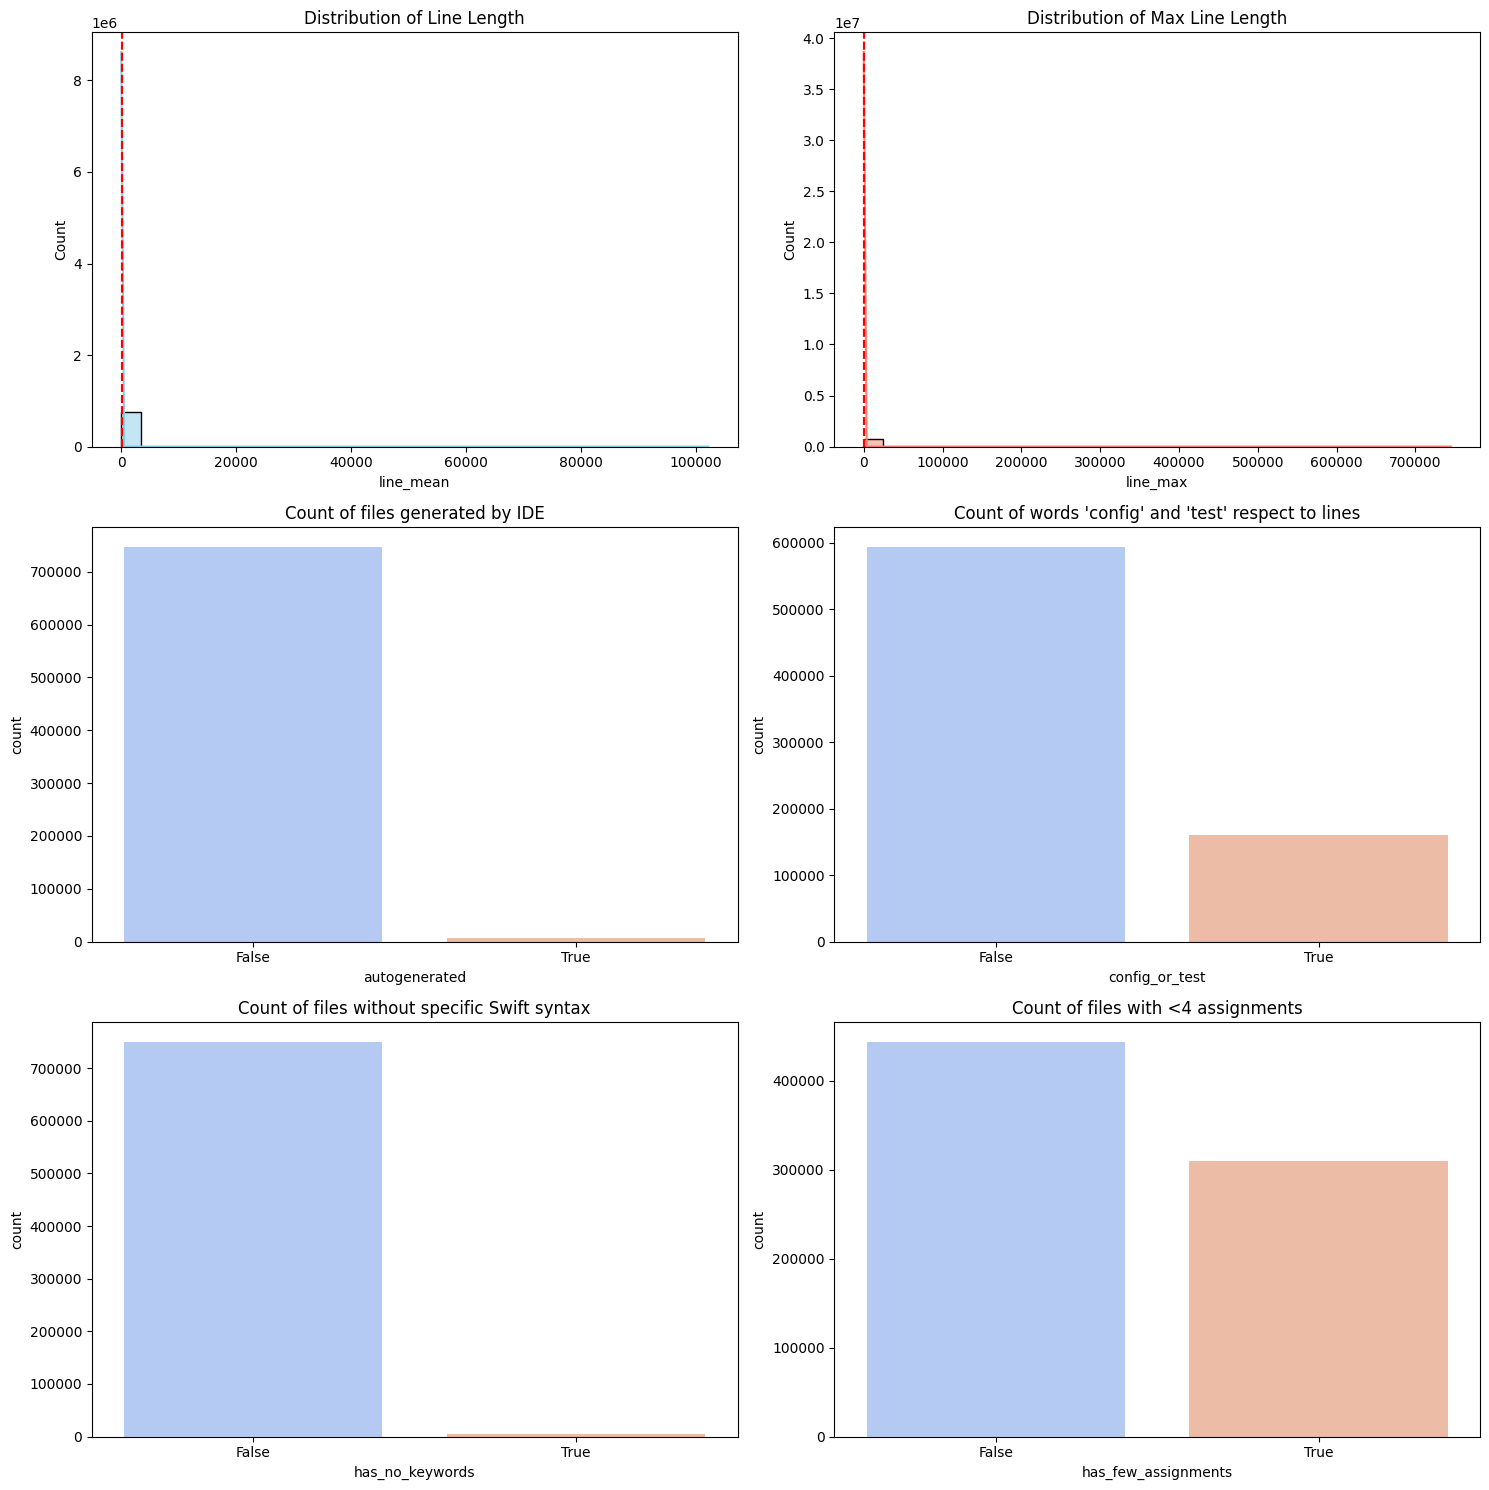

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the 99th percentiles
percentile_99_line_mean = df_train['line_mean'].quantile(0.99)
percentile_99_line_max = df_train['line_max'].quantile(0.99)

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot the distribution of line_mean with 99th percentile
sns.histplot(df_train['line_mean'], ax=axes[0, 0], bins=30, kde=True, color='skyblue')
axes[0, 0].axvline(percentile_99_line_mean, color='red', linestyle='--')
axes[0, 0].set_title('Distribution of Line Length')
axes[0, 0].axvline(percentile_99_line_mean, color='red', linestyle='--', label=f'99th Percentile: {percentile_99_line_mean:.2f}')


# Plot the distribution of line_max with 99th percentile
sns.histplot(df_train['line_max'], ax=axes[0, 1], bins=30, kde=True, color='salmon')
axes[0, 1].axvline(percentile_99_line_max, color='red', linestyle='--')
axes[0, 1].set_title('Distribution of Max Line Length')
axes[0, 1].axvline(percentile_99_line_max, color='red', linestyle='--', label=f'99th Percentile: {percentile_99_line_max:.2f}')


# Bar plots for the boolean fields
bool_columns = ['autogenerated', 'config_or_test', 'has_no_keywords', 'has_few_assignments']
bool_title = {
    'autogenerated': 'files generated by IDE',
    'config_or_test':"words 'config' and 'test' respect to lines",
    'has_no_keywords': 'files without specific Swift syntax',
    'has_few_assignments': 'files with <4 assignments'
}
for idx in range(1, 3):
    sns.countplot(data=df_train, x=bool_columns[2*(idx-1)], ax=axes[idx, 0], palette="coolwarm")
    axes[idx, 0].set_title(f'Count of {bool_title[bool_columns[2*(idx-1)]]}')
    sns.countplot(data=df_train, x=bool_columns[2*(idx-1) + 1], ax=axes[idx, 1], palette="coolwarm")
    axes[idx, 1].set_title(f'Count of {bool_title[bool_columns[2*(idx-1) + 1]]}')

plt.tight_layout()
plt.savefig('3x2_grid_plot.svg', format='svg')
plt.show()


In [38]:
def filter(example, uniques):
    """Filter dataset with heuristics. Config, test and has_no_keywords files are removed with a given probability."""
    if not check_uniques(example, uniques):
        return False
    elif example["autogenerated"]:
        return False
    elif example["line_max"] > percentile_99_line_max:
        return False
    elif example["line_mean"] > percentile_99_line_mean:
        return False
    elif example["config_or_test"] and np.random.rand() <= 0.7:
        return False
    elif example["has_no_keywords"] and np.random.rand() <= 0.7:
        return False
    elif example["has_few_assignments"]:
        return False
    else:
        return True

In [39]:
# Deduplicate data and apply heuristics
t_start = time.time()
ds_filter = ds['train'].filter(filter, fn_kwargs={"uniques": uniques})
print(f"Time to filter dataset: {time.time()-t_start:.2f}")
print(f"Size of filtered dataset: {len(ds_filter)}")

Filter:   0%|          | 0/753684 [00:00<?, ? examples/s]

Time to filter dataset: 16.10
Size of filtered dataset: 377225


In [65]:
!pip install datasketch
!pip install dpu-utils
!pip install tqdm
from minhash_deduplication import deduplicate_dataset

In [66]:
t_start = time.time()
ds_filter, duplicate_clusters = deduplicate_dataset(ds_filter)
print(f"Time to deduplicate dataset: {time.time()-t_start:.2f}")
print(f"Size of deduplicate dataset: {len(ds_filter)}")

377223it [08:13, 763.77it/s] 
100%|██████████| 37579/37579 [00:54<00:00, 684.14it/s] 


Filter:   0%|          | 0/377225 [00:00<?, ? examples/s]

Original dataset size: 377225
Number of duplicate clusters: 37579
Files in duplicate cluster: 114599
Unique files in duplicate cluster: 46265
Filtered dataset size: 308891
Time to deduplicate dataset: 588.31
Size of deduplicate dataset: 308891


In [69]:
df_filter = pd.DataFrame(ds_filter)



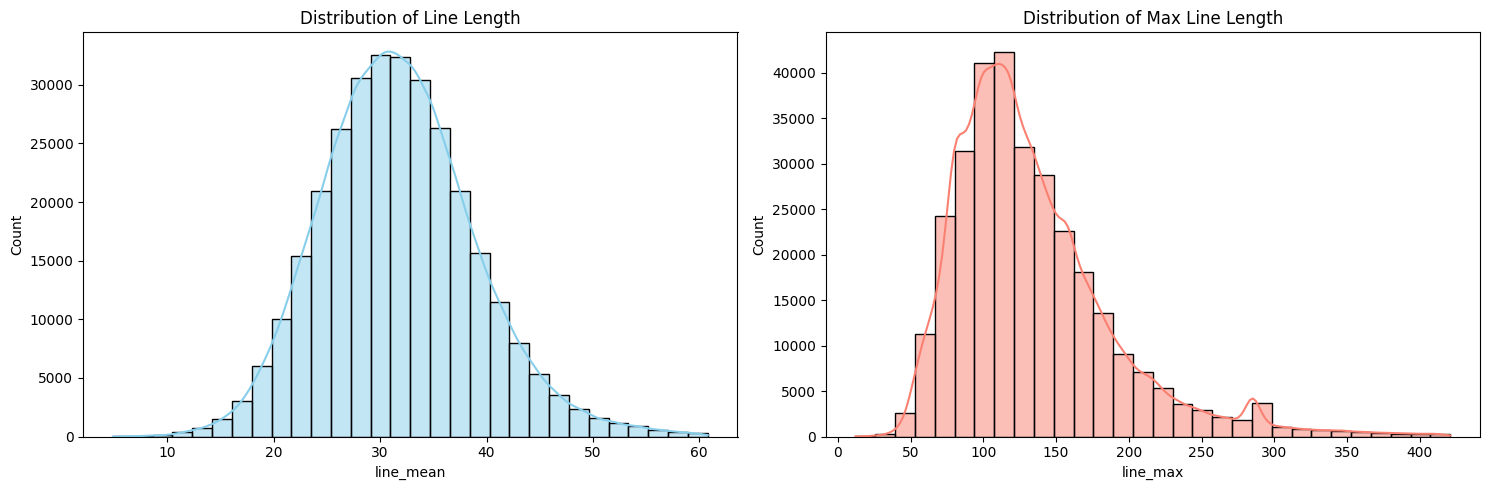

In [70]:

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot the distribution of line_mean with 99th percentile
sns.histplot(df_filter['line_mean'], ax=axes[0], bins=30, kde=True, color='skyblue')
axes[0].set_title('Distribution of Line Length')
#axes[0, 0].axvline(percentile_99_line_mean, color='red', linestyle='--', label=f'99th Percentile: {percentile_99_line_mean:.2f}')


# Plot the distribution of line_max with 99th percentile
sns.histplot(df_filter['line_max'], ax=axes[1], bins=30, kde=True, color='salmon')
axes[1].set_title('Distribution of Max Line Length')
#axes[0, 1].axvline(percentile_99_line_max, color='red', linestyle='--', label=f'99th Percentile: {percentile_99_line_max:.2f}')


plt.tight_layout()
plt.savefig('3x2_grid_plot_new.svg', format='svg')
plt.show()


In [68]:
ds_filter

Dataset({
    features: ['repo_name', 'ref', 'path', 'license', 'copies', 'content', 'hash', 'line_mean', 'line_max', 'alpha_frac', 'autogenerated', 'config_or_test', 'has_no_keywords', 'has_few_assignments'],
    num_rows: 308891
})

In [58]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [71]:
ds_filter.push_to_hub('bigquery-swift-unfiltered-no-duplicate')

Pushing dataset shards to the dataset hub:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/103 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/103 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/103 [00:00<?, ?ba/s]